In [47]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

from diffeq import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
def f1(y, t):
    return y + t**2.0

In [49]:
def f2(y):
    return (y+10**-3) * math.sin(math.pi/2 * y+10**-3)

In [50]:
def f3(y, c):
    return c - y**2

In [51]:
a = 2
b = 1.2
c = 1
d = 0.9

def pp(ys, t):
    return [
        a*ys[0] - b*ys[0]*ys[1],
        -c*ys[1] + d*ys[0]*ys[1]
    ]

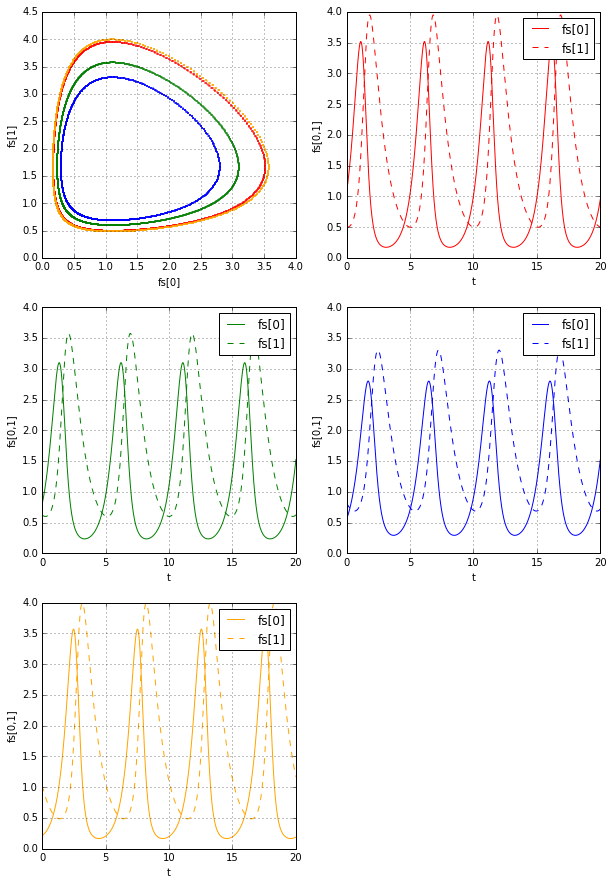

In [52]:
plot_solution_and_components(pp, 
    ics=[(10,[1,0.5]), (10,[1.1,0.6]), (10,[0.9,0.7]), (10,[0.2,1.1])], 
    args=None, 
    t_lim=(0,20), y_lims=[(0,4),(0,4.5)], t_del=0.01)

In [53]:
def pp2(ys, t):
    return [
        2*ys[0]*(1-ys[0]/2.5)-1.5*ys[0]*ys[1],
        -ys[1]+0.8*ys[0]*ys[1]
    ]

/usr/local/lib/python3.4/dist-packages/scipy/integrate/odepack.py:156: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


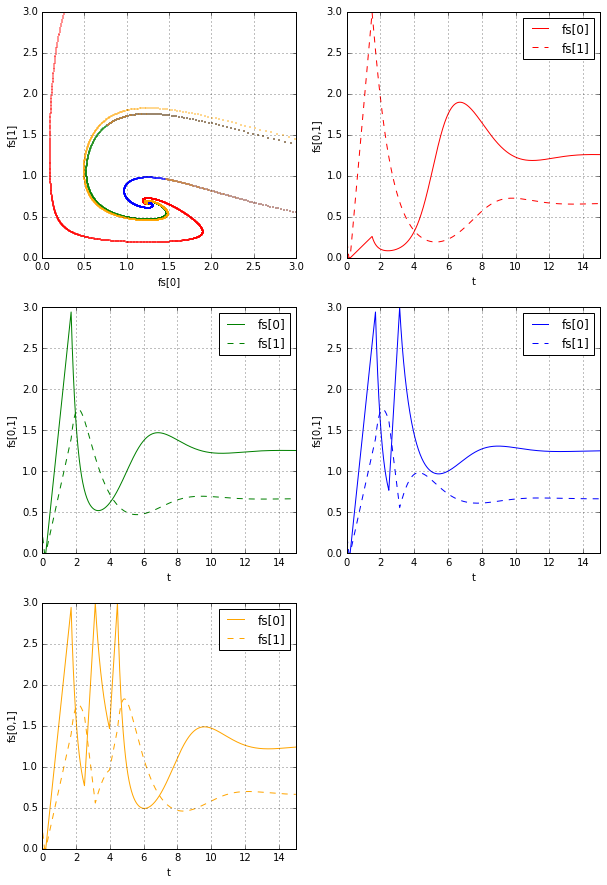

In [54]:
plot_solution_and_components(pp2, 
    ics=[(5,[1,0.2]),(5,[1,0.5]),(5,[1,0.9]),(5,[1,1.8])], 
    args=None, 
    t_lim=(0,15), y_lims=[(0,3),(0,3)], t_del=0.01)

---

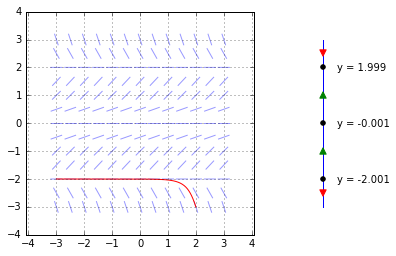

In [55]:
plot_ode_solution(f2, ic=(2,-3), c=None,
    slope_field_step=(.5,.5), t_lim=(-3,3), y_lim=(-3,3))

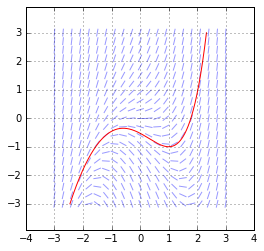

In [56]:
plot_ode_solution(f1, ic=(1,-1), c=None,
    slope_field_step=(.3,.3), t_lim=(-3,3), y_lim=(-3,3))

/usr/local/lib/python3.4/dist-packages/scipy/integrate/odepack.py:156: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


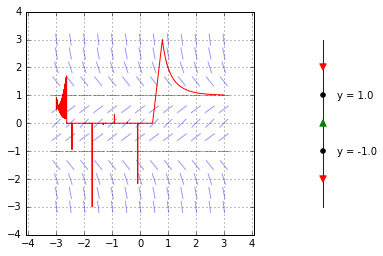

In [57]:
plot_ode_solution(f3, ic=(1,2), c=1,
    slope_field_step=(.5,.5), t_lim=(-3,3), y_lim=(-3,3), t_del=1e-3)

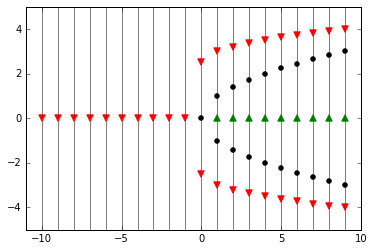

In [58]:
plot_parameterized_phase_lines(f3, range(-10,10), (-5,5))